In [1]:
%matplotlib inline

In [80]:
import pandas as pd
import numpy as np
from numpy import linalg
import re
from sklearn import preprocessing
from nltk.stem.porter import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import k_means
from sklearn.metrics import accuracy_score

#### Load the Data

In [81]:
def load(file):
    df = []
    with open(file, 'r') as f:
        for line in f.readlines():
            n = line.strip().split('\t')
            if len(n) == 2:
                df.append({'review' : n[0], 'label' : int(n[1])}) 
    return pd.DataFrame(df)

In [82]:
#Load the Data
yelp = load('yelp_labelled.txt')
amazon = load('amazon_cells_labelled.txt')
imdb = load('imdb_labelled.txt')

#### Inspect Ratio

In [83]:
yelp['label'].value_counts()

1    500
0    500
Name: label, dtype: int64

In [84]:
amazon['label'].value_counts()

1    500
0    500
Name: label, dtype: int64

In [85]:
imdb['label'].value_counts()

1    500
0    500
Name: label, dtype: int64

#### Pre-Processing

In [86]:
#Lowercase:
yelp['review'] = yelp['review'].str.lower()
amazon['review'] = amazon['review'].str.lower()
imdb['review'] = imdb['review'].str.lower()

yelp.dropna()
amazon.dropna()
imdb.dropna()

,label,review
0,0,"a very, very, very slow-moving, aimless movie ..."
1,0,not sure who was more lost - the flat characte...
2,0,attempting artiness with black & white and cle...
3,0,very little music or anything to speak of.
4,1,the best scene in the movie was when gerardo i...
5,0,"the rest of the movie lacks art, charm, meanin..."
6,0,wasted two hours.
7,1,saw the movie today and thought it was a good ...
8,0,a bit predictable.
9,1,loved the casting of jimmy buffet as the scien...


In [87]:
punctuation = re.compile(r'([^A-Za-z0-9 ])')
def puncRem(review):
    return punctuation.sub("", review)

In [88]:
#http://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html
stop_words = (['a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he', 'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'were', 'will', 'with'])
st = PorterStemmer()
def StemStop(review):
    return ' '.join([st.stem(word) for word in review.split() if word not in stop_words])

In [89]:
def cleanAll(file):
    rev = list(file['review'])
    def clean(revs):
        return StemStop(puncRem(revs))
    return [clean(row) for row in rev]

In [90]:
#Cleaned Files
amazonCl = amazon
yelpCl = yelp
imdbCl = imdb

amazonCl['review'] = cleanAll(amazon)
yelpCl['review'] = cleanAll(yelp)
imdbCl['review'] = cleanAll(imdb)

### Split Train/Test

In [91]:
def train(file):
    label0,label1=file[file.label==0],file[file.label==1]
    train0,test0=label0[:400],label0[400:]
    train1,test1 = label1[:400],label1[400:]
    return train1.append(train0, ignore_index = True), test1.append(test0, ignore_index = True)

In [92]:
imdbTrain, imdbTest = train(imdbCl)
yelpTrain, yelpTest = train(yelpCl)
amazonTrain, amazonTest = train(amazonCl)

In [93]:
trainSet=imdbTrain.append(amazonTrain,ignore_index=True).append(yelpTrain, ignore_index=True)
testSet=imdbTest.append(amazonTest,ignore_index=True).append(yelpTest, ignore_index=True)

### Bag of Words

In [94]:
wDict={}
wList=[]

In [95]:
def wordLoc(file):
    p = 0
    for review in file['review']:
        for word in review.split(' '):
            if not word in wDict:
                wDict[word] = p
                p += 1
                wList.append(word)

In [96]:
wordLoc(trainSet)

In [97]:
def featureExt(file):
    x=len(wDict)
    y=len(file['review'])
    num=np.zeros((y,x),dtype=np.int)
    for p,review in enumerate(file['review']):
        for word in review.split(' '):
            if word in wDict:
                num[p][wDict[word]]+=1
    return num

In [98]:
def cen(file):
    avg=np.mean(file,axis=0)
    return file-avg

In [99]:
featureTrain = featureExt(trainSet)
featureTest = featureExt(testSet)

In [100]:
trainL=trainSet['label']
testL=testSet['label']

(array([ 3743.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,    13.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

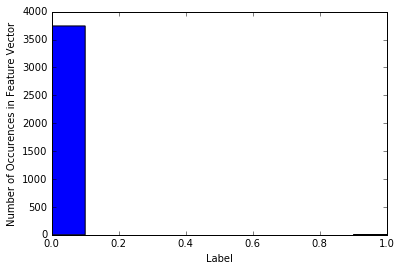

In [101]:
import matplotlib.pyplot as plt
plt.xlabel('Label')
plt.ylabel('Number of Occurences in Feature Vector')
plt.hist(featureTrain[0])

(array([  3.74800000e+03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   7.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

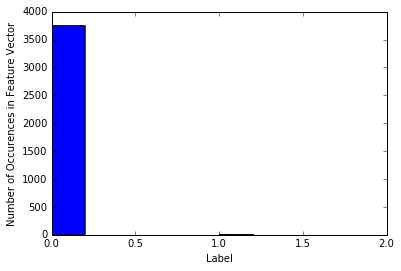

In [102]:
plt.xlabel('Label')
plt.ylabel('Number of Occurences in Feature Vector')
plt.hist(featureTrain[1])

### E -- PreProcess

In [103]:
def l2Norm(file,norm='l2'):
    return preprocessing.normalize(file.astype(np.float64), norm=norm)

In [104]:
nFeatTrain = l2Norm(featureTrain)

In [105]:
nFeatTest = l2Norm(featureTest)

#### F -- Clustering

In [106]:
#calc distance
def l2D(a,b):
    return np.linalg.norm(a-b)

In [107]:
def centPoint(cents,points):
    r=[None for _ in range(len(cents))]
    for point in points:
        i=centers(cents,point)
        if r[i] is None:
            r[i]=point
        else:
            r[i]=np.vstack((r[i],point))
    return r

In [108]:
def centers(cents,a):
    resI,dist=-1,float('inf')
    for i,cent in enumerate(cents):
        newD=l2D(cent,a)
        if newD < dist:
            resI,dist = i,newD
    return resI

In [109]:
#K-Centroids
def kCen(s,feat,K=2):
    def end(c1,c2):
        for i in range(len(c1)):
            cIn, next = c1[i],c2[i]
            if not np.allclose(cIn,next,rtol=1e-4,atol=1e-6):
                return False
        return True
    m=centPoint(s,feat)
    c1, c2 = s,[np.mean(mat,axis=0) for mat in m]
    t = 1
    while not end(c1,c2):
        print("rep " + str(t))
        t += 1
        m=centPoint(c2,feat)
        c1 = c2
        c2 = [mat.mean(0) for mat in m]
    l=np.zeros((feat.shape[0],1), dtype=np.int)
    for index, point in enumerate(feat):
        i=centers(c2, point)
        l[index, 0] = i
    return c2,l

In [110]:
#p1,p2=np.random.choice(nFeatTrain.shape[0],2,replace=False)
#s=nFeatTrain[[p1,p2]]
#cen,lab=kCen(s,nFeatTrain)

In [111]:
print(cen[0])

TypeError: 'function' object is not subscriptable

In [112]:
print(cen[1])

TypeError: 'function' object is not subscriptable

In [113]:
accuracy_score(trainL,lab)

0.51249999999999996

#### G Sentiment Prediction

In [114]:
logreg = LogisticRegression()
logreg.fit(nFeatTrain,trainL)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [115]:
classification_accuracy=logreg.score(nFeatTest, testL)

In [116]:
classification_accuracy

0.81499999999999995

In [117]:
pred=logreg.predict(nFeatTest)
rank=logreg.coef_

In [118]:
cm=confusion_matrix(testL,pred)

In [119]:
cm

array([[260,  40],
       [ 71, 229]])

In [ ]:
print('Top Negative Words:')
for negativeWords in rank.argsort()[0,:10]:
    print(wList[negativeWords])

In [120]:
print('Top Positive Words:')
for positiveWords in rank.argsort()[0,-10:]:
    print(wList[positiveWords])

Top 10 Positive Words:
awesom
fantast
best
amaz
delici
nice
excel
good
love
great


#### H -- N-Gram Model 

In [122]:
nD={}
nL=[]

In [204]:
def nGram(file,n=2):
    y=len(file['review'])
    x=len(nD)
    df=np.zeros((y,x),dtype=np.int)
    for i,review in enumerate(file['review']):
        sp=review.split(' ')
        for spI in range(len(sp)-n+1):
            gr=' '.join(sp[spI: (spI+n)])
            if gr in nD:
                df[i][nD[gr]] += 1
    return df

In [205]:
nGrTrain=nGram(trainSet)

In [224]:
nGrTrain=nGram(trainSet)

In [225]:
nGrTest=nGram(testSet)

In [226]:
#clustering

In [227]:
normNTrain = l2Norm(nGrTrain)

In [228]:
normNTest = l2Norm(nGrTest)

### N-Gram Clustering

In [238]:
#p1,p2=np.random.choice(normNTrain.shape[0],2,replace=False)
#sN=nFeatTrain[[p1,p2]]
#cenN,labN=kCen(sN,normNTrain)

IndexError: tuple index out of range

In [240]:
#accuracy_score(trainL,labN)

##### N-Gram LogReg

In [242]:
logreg=LogisticRegression()

In [243]:
logreg.fit(nGrTrain,trainL)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [244]:
logreg.score(nGrTest,testL)

0.66666666666666663

In [245]:
pred=logreg.predict(normNTest)

In [246]:
rank=logreg.coef_

In [247]:
cm=confusion_matrix(testL,pred)

In [248]:
cm

array([[164, 136],
       [ 66, 234]])

In [ ]:
print('Top Negative Words:')
for negativeNWords in rank.argsort()[0,:10]:
    print(nL[negativeNWords])

In [249]:
print('Top Positive Words:')
for positiveNWords in rank.argsort()[0,-10:]:
    print(nL[positiveNWords])

Top Positive Words:
realli good
one best
great product
love thi
great phone
i like
highli recommend
veri good
i love
work great


### PCA 

In [251]:
def pcaBow(file,n=10):
    U,s,V=np.linalg.svd(file,full_matrices=True)
    print(U.shape)
    diag=np.diag(s[:n])
    print(diag.shape)
    return np.dot(U[:,:n], diag)

In [262]:
def orig(f,n=2):
    p1,p2=np.random.choice(f.shape[0],2, replace=False)
    st=f[[p1,p2]]
    return st

In [274]:
#10 Dim
pca10=pcaBow(featureTrain,10)

(2400, 2400)
(10, 10)


In [275]:
init10=orig(pca10)

In [276]:
cenP10,labP10=kCen(init10,pca10)

rep 1
rep 2


In [277]:
print(cenP10)

[array([-1.30944559,  0.31371087, -0.07462802, -0.02299582,  0.02241633,
       -0.00682884,  0.01095005,  0.02278861,  0.01550476, -0.00749205]), array([-0.22752417, -0.21678633,  0.19497451,  0.03130513,  0.03062976,
       -0.03731632, -0.05776535, -0.02125374, -0.02901379,  0.00241722])]


In [278]:
accuracy_score(trainL, labP10)

0.51500000000000001

In [ ]:
#50 Dim

In [285]:
pca50=pcaBow(featureTrain,50)

(2400, 2400)
(50, 50)


In [286]:
init50=orig(pca50)

In [287]:
cenP50,labP50=kCen(init50,pca50)

rep 1
rep 2
rep 3
rep 4
rep 5
rep 6
rep 7
rep 8
rep 9


In [288]:
print(cenP50)

[array([-0.26705591,  0.01729417,  0.22013331,  0.00234731,  0.04747285,
       -0.05266547, -0.05774851, -0.02263913, -0.02524832, -0.00269532,
       -0.01640023,  0.03682777,  0.02986614, -0.03191748,  0.01239044,
        0.01983827, -0.0123185 , -0.00454153,  0.01553588,  0.01142822,
       -0.00783259,  0.00541276,  0.00278651, -0.01580407,  0.01186352,
        0.00935641, -0.0267716 , -0.0115688 , -0.01096688,  0.01124752,
        0.00362975, -0.00039584, -0.00971327,  0.00151504,  0.00276035,
        0.00943089,  0.00699666, -0.01147739, -0.00725691, -0.00578802,
        0.00812835, -0.00091492,  0.00446555, -0.00050206, -0.00209186,
        0.0120709 ,  0.01015445, -0.00816808,  0.00144158, -0.00585642]), array([ -1.16445938e+00,  -3.90171041e-01,  -1.41685450e-01,
         6.37825189e-02,  -2.70103478e-02,   3.76084392e-02,
         9.09210153e-03,   2.57128533e-02,   3.23499351e-03,
         7.83724517e-03,  -2.61857197e-03,  -9.44419747e-03,
        -1.89252411e-02,   3.1128

In [289]:
accuracy_score(trainL,labP50)

0.4975

In [290]:
#100 Dim

In [291]:
pca100=pcaBow(featureTrain,100)

(2400, 2400)
(100, 100)


In [292]:
init100=orig(pca100)

In [293]:
cenP100,labP100=kCen(init100,pca100)

rep 1
rep 2
rep 3
rep 4
rep 5
rep 6


In [294]:
print(cenP100)

[array([ -2.26633595e-01,  -2.15357657e-01,   1.95660929e-01,
         3.11633569e-02,   3.07608750e-02,  -3.73504289e-02,
        -5.79346398e-02,  -2.12209210e-02,  -2.88889963e-02,
         2.17122130e-03,  -1.91569918e-02,   3.10372280e-02,
         1.93335096e-02,  -1.60089626e-02,   1.27355258e-02,
         1.65678548e-02,  -8.16981466e-03,   1.76070530e-03,
         1.40602478e-02,   2.58738937e-03,  -9.55183504e-03,
         1.23966485e-03,   4.71616063e-03,  -1.43723489e-02,
         8.50081371e-03,   8.75984799e-03,  -2.60533781e-02,
        -1.32421136e-02,  -6.30573560e-03,   1.18774277e-02,
         1.20906017e-03,   7.94095621e-04,  -3.89831560e-03,
        -2.91812677e-03,   2.41566269e-03,   1.07146383e-02,
         9.02156655e-03,  -6.20021536e-03,  -6.69803542e-03,
        -2.90336810e-03,   8.24768550e-03,   1.15731108e-03,
         6.97924184e-03,   1.45055590e-03,  -3.12006742e-04,
         1.19589615e-02,   9.61611162e-03,  -4.99738521e-03,
        -2.50477997e-03

In [295]:
accuracy_score(trainL,labP100)

0.48541666666666666